In [103]:
import numpy as np
import cv2
import openslide
from PIL import Image,ImageDraw
import operator
import matplotlib as mpl
import matplotlib.pyplot as plt

In [33]:
def get_tile(img_fname,desired_mpp,coords=(0,0),wh=(256, 256)):

    osh_img = openslide.OpenSlide(img_fname)

    img_dim=osh_img.level_dimensions        
    img_mpp = round(float(osh_img.properties['openslide.mpp-x']),2)
    downsample_factors = osh_img.level_downsamples

    img_mpps = [ds*img_mpp for ds in downsample_factors]
    diff_mpps = [abs(x) for x in [mpp - float(desired_mpp) for mpp in img_mpps]]
    target_layer = diff_mpps.index(min(diff_mpps))    

    upscale_for_layer = desired_mpp / img_mpps[target_layer]
        
    img_image = osh_img.read_region(coords,target_layer,[int(float(dimension) * upscale_for_layer) for dimension in wh])
    
    interp_method=PIL.Image.NEAREST #want to use nearest! otherwise resizing may cause non-existing classes to be produced via interpolation (e.g., ".25")
    img = img_image.resize(wh, resample=interp_method) #resize it as specified above
    
    img = np.asarray(img)[:,:,0:3]
    
    return img


In [120]:
def show_tile_location(img_fname,desired_mpp,coords=(0,0),wh=(256, 256)):
    
    wsi_mpp = 8
    
    osh_img = openslide.OpenSlide(img_fname)

    img_dim=osh_img.level_dimensions        
    img_mpp = round(float(osh_img.properties['openslide.mpp-x']),2)
    downsample_factors = osh_img.level_downsamples

    img_mpps = [ds*img_mpp for ds in downsample_factors]
    diff_mpps = [abs(x) for x in [mpp - float(desired_mpp) for mpp in img_mpps]]
    target_layer = diff_mpps.index(min(diff_mpps))    
    
    wsi_diff_mpps = [abs(x) for x in [mpp - float(wsi_mpp) for mpp in img_mpps]]
    wsi_target_layer = wsi_diff_mpps.index(min(wsi_diff_mpps))    

    upscale_for_layer = desired_mpp / img_mpps[target_layer]
    
    coords = tuple([int(c/downsample_factors[wsi_target_layer]) for c in coords])
    wh = tuple([int(dim/downsample_factors[wsi_target_layer]) for dim in wh])
    wsi_image = osh_img.read_region((0,0),wsi_target_layer,img_dim[wsi_target_layer])        
    
    tile_rect = ImageDraw.Draw(wsi_image)
    outer_point = tuple(map(operator.add,coords,tuple([int(float(dimension) * upscale_for_layer) for dimension in wh])))
    tile_rect.rectangle((coords,outer_point),outline="#000000",width=10)
    
    return wsi_image


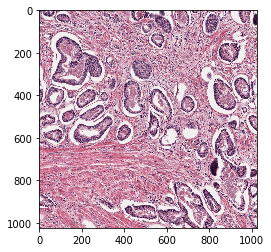

In [122]:
img_fname=r'/mnt/data/home/pjl54/UPenn_prostate/20698.svs'
desired_mpp = 1
coords=(10846,25368)
wh=(1024,1024)

img = get_tile(img_fname=img_fname,desired_mpp=desired_mpp,coords=coords,wh=wh)
plt.imshow(img)

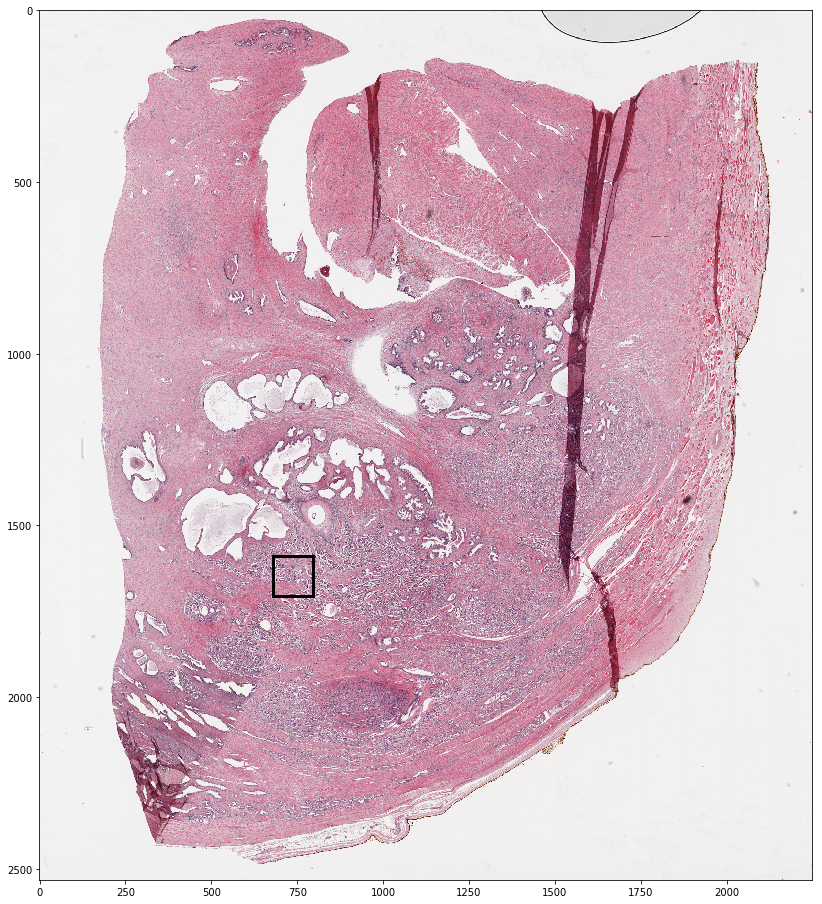

In [123]:
wsi_img = show_tile_location(img_fname=img_fname,desired_mpp=desired_mpp,coords=coords,wh=wh)
fig = plt.figure(figsize=(18, 16))
plt.imshow(wsi_img,)